<a href="https://colab.research.google.com/github/luispc1989/ModelatingForestEcosystems/blob/main/19724_homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.optimize import curve_fit
import scipy.stats as stats
import pylab
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define path of file
data_path = "/content/drive/MyDrive/Homework_1/Homework1_data.xlsx"

In [ ]:
# Load data
xls = pd.ExcelFile(data_path)
metadata_df = pd.read_excel(xls, sheet_name='metadata ')
data_df = pd.read_excel(xls, sheet_name='19724')

# Remove NaN values and ensure positive values
data_df = data_df.dropna(subset=['d (cm)', 'h (m)'])
data_df = data_df[(data_df['d (cm)'] > 0) & (data_df['h (m)'] > 0)]

# Renaming variables for consistency
data_df = data_df.rename(columns={'d (cm)': 'x', 'h (m)': 'y'})  # x = diameter y = total height


In [ ]:
# Task A - Compute descriptive statistics for diameter (x) and total height (y)
stats_dict = {
    "Metric": ["Mean", "Median", "Mode", "25th Percentile (Q1)", "75th Percentile (Q3)", "Standard Deviation",
               "Interquartile Range (IQR)", "Coefficient of Variation (CV %)", "Min", "Max",
               "Lower Whisker (1.5*IQR)", "Upper Whisker (1.5*IQR)"],

    "Diameter (x cm)": [
        round(data_df['x'].mean(), 2),
        round(data_df['x'].median(), 2),
        round(data_df['x'].mode().iloc[0], 2),
        round(data_df['x'].quantile(0.25), 2),  # Q1
        round(data_df['x'].quantile(0.75), 2),  # Q3
        round(data_df['x'].std(), 2),
        round(data_df['x'].quantile(0.75) - data_df['x'].quantile(0.25), 2),  # IQR
        round((data_df['x'].std() / data_df['x'].mean()) * 100, 2),
        round(data_df['x'].min(), 2),
        round(data_df['x'].max(), 2),

        # Lower Whisker: Q1 - 1.5 * IQR (but cannot be less than the actual minimum)
        max(round(data_df['x'].quantile(0.25) - 1.5 * (data_df['x'].quantile(0.75) - data_df['x'].quantile(0.25)), 2),
            data_df['x'].min()),

        # Upper Whisker: Q3 + 1.5 * IQR (but cannot be greater than the actual maximum)
        min(round(data_df['x'].quantile(0.75) + 1.5 * (data_df['x'].quantile(0.75) - data_df['x'].quantile(0.25)), 2),
            data_df['x'].max())
    ],

    "Total Height (y m)": [
        round(data_df['y'].mean(), 2),
        round(data_df['y'].median(), 2),
        round(data_df['y'].mode().iloc[0], 2),
        round(data_df['y'].quantile(0.25), 2),  # Q1
        round(data_df['y'].quantile(0.75), 2),  # Q3
        round(data_df['y'].std(), 2),
        round(data_df['y'].quantile(0.75) - data_df['y'].quantile(0.25), 2),  # IQR
        round((data_df['y'].std() / data_df['y'].mean()) * 100, 2),
        round(data_df['y'].min(), 2),
        round(data_df['y'].max(), 2),

        # Lower Whisker: Q1 - 1.5 * IQR (but cannot be less than the actual minimum)
        max(round(data_df['y'].quantile(0.25) - 1.5 * (data_df['y'].quantile(0.75) - data_df['y'].quantile(0.25)), 2),
            data_df['y'].min()),

        # Upper Whisker: Q3 + 1.5 * IQR (but cannot be greater than the actual maximum)
        min(round(data_df['y'].quantile(0.75) + 1.5 * (data_df['y'].quantile(0.75) - data_df['y'].quantile(0.25)), 2),
            data_df['y'].max())
    ]
}

stats_df = pd.DataFrame(stats_dict)

# Table display
print(tabulate(stats_df, headers='keys', tablefmt='fancy_grid', numalign="center", stralign="center"))


╒════╤═════════════════════════════════╤═══════════════════╤══════════════════════╕
│    │             Metric              │  Diameter (x cm)  │  Total Height (y m)  │
╞════╪═════════════════════════════════╪═══════════════════╪══════════════════════╡
│ 0  │              Mean               │       17.4        │        11.06         │
├────┼─────────────────────────────────┼───────────────────┼──────────────────────┤
│ 1  │             Median              │       14.4        │         9.9          │
├────┼─────────────────────────────────┼───────────────────┼──────────────────────┤
│ 2  │              Mode               │        10         │         8.2          │
├────┼─────────────────────────────────┼───────────────────┼──────────────────────┤
│ 3  │      25th Percentile (Q1)       │       10.5        │         8.2          │
├────┼─────────────────────────────────┼───────────────────┼──────────────────────┤
│ 4  │      75th Percentile (Q3)       │       20.9        │         13.3   

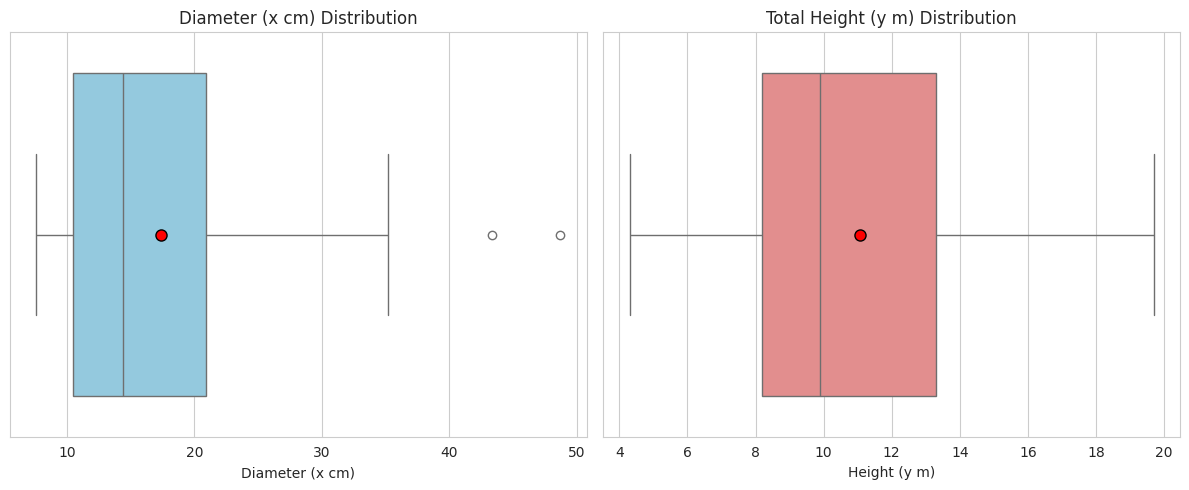

In [ ]:
# Plot boxplots with mean indicators
plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")

# Boxplot of diameter (x)
plt.subplot(1, 2, 1)
sns.boxplot(x=data_df['x'], color="skyblue", showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"black", "markersize":8})
plt.title("Diameter (x cm) Distribution")
plt.xlabel("Diameter (x cm)")

# Boxplot of total height (y)
plt.subplot(1, 2, 2)
sns.boxplot(x=data_df['y'], color="lightcoral", showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"black", "markersize":8})
plt.title("Total Height (y m) Distribution")
plt.xlabel("Height (y m)")
plt.tight_layout()
plt.show()


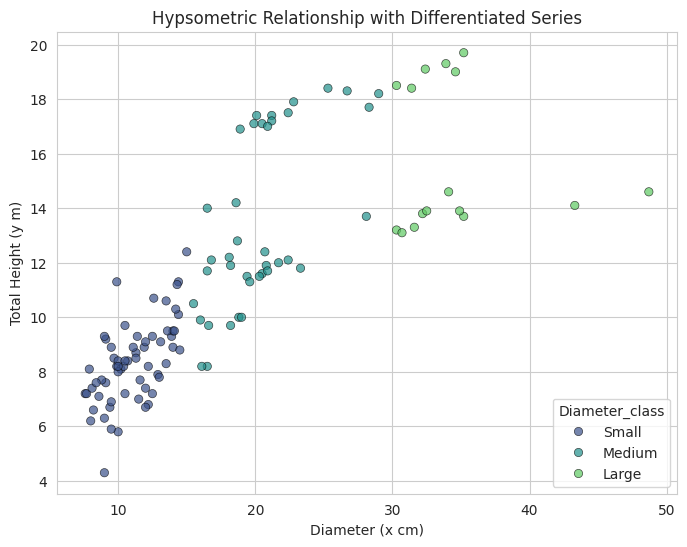

In [ ]:
# Task B - Plot hypsometric relationship with different data series (diameter vs height)

# Identify a categorical variable if available in the dataset
categorical_column = None
possible_columns = ['plot', 'species', 'group', 'stand']

for col in possible_columns:
    if col in data_df.columns:
        categorical_column = col
        break  # Stop searching once a valid column is found

# If no categorical column is found, create artificial categorization based on diameter size
if not categorical_column:
    data_df['diameter_class'] = pd.cut(data_df['x'], bins=[0, 15, 30, 50], labels=["Small", "Medium", "Large"])
    categorical_column = 'diameter_class'

# Create scatter plot of height vs diameter with different series
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_df, x='x', y='y', hue=categorical_column, alpha=0.7, edgecolor='black', palette="viridis")

# Adjust legend position to bottom right
plt.legend(title=categorical_column.capitalize(), loc='lower right')
plt.xlabel("Diameter (x cm)")
plt.ylabel("Total Height (y m)")
plt.title("Hypsometric Relationship with Differentiated Series")
plt.grid(True)
plt.show()


In [ ]:
# Define function for regression (common allometric equation: y = k * x^a)
def allometric_function(x, k, a):
    return k * (x ** a)

# Fit curve to data
params, covariance = curve_fit(allometric_function, data_df['x'], data_df['y'])
k, a = params

# Generate fitted values
x_fit = np.linspace(min(data_df['x']), max(data_df['x']), 100)
y_fit = allometric_function(x_fit, k, a)

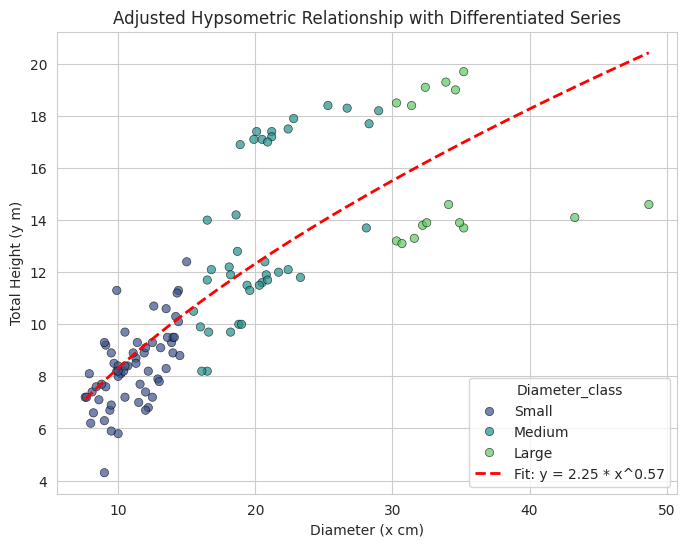

In [ ]:
# Plot regression curve

# Identify a categorical variable if available in the dataset
categorical_column = None
possible_columns = ['plot', 'species', 'group', 'stand']

for col in possible_columns:
    if col in data_df.columns:
        categorical_column = col
        break  # Stop searching once a valid column is found

# If no categorical column is found, create artificial categorization based on diameter size
if not categorical_column:
    data_df['diameter_class'] = pd.cut(data_df['x'], bins=[0, 15, 30, 50], labels=["Small", "Medium", "Large"])
    categorical_column = 'diameter_class'

# Create scatter plot with different series along with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_df, x='x', y='y', hue=categorical_column, alpha=0.7, edgecolor='black', palette="viridis")
plt.plot(x_fit, y_fit, color='red', linestyle="--", linewidth=2, label=f'Fit: y = {k:.2f} * x^{a:.2f}')

# Adjust labels, title, and legend
plt.xlabel("Diameter (x cm)")
plt.ylabel("Total Height (y m)")
plt.title("Adjusted Hypsometric Relationship with Differentiated Series")
plt.legend(title=categorical_column.capitalize())
plt.grid(True)
plt.show()


In [ ]:
# Print fitted parameters
print(f"Parâmetros ajustados: k = {k:.2f}, a = {a:.2f}")

Parâmetros ajustados: k = 2.25, a = 0.57


In [ ]:
# Task C - Fit Model 11 from Paulo et al. (2011)
def height_diameter_model(du, a, b):
    return 1.3 + (du / (a + b * du))

# Fit the model to the data
params, covariance = curve_fit(height_diameter_model, data_df['x'], data_df['y'], p0=[1, 0.1])

# Extract estimated parameters
a_fit, b_fit = params

# Generate fitted values
du_fit = np.linspace(min(data_df['x']), max(data_df['x']), 100)
h_fit = height_diameter_model(du_fit, a_fit, b_fit)

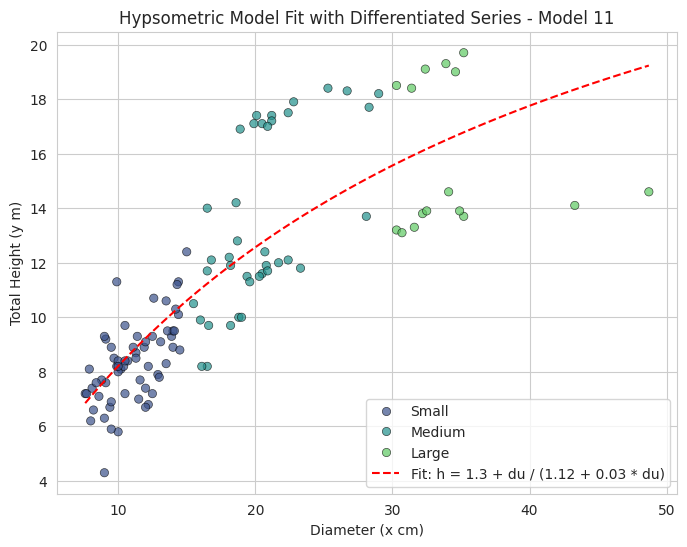

In [ ]:
# Plot the fitted model
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_df, x='x', y='y', hue='diameter_class', alpha=0.7, edgecolor='black', palette="viridis")
plt.plot(du_fit, h_fit, color='red', linestyle="--",label=f'Fit: h = 1.3 + du / ({a_fit:.2f} + {b_fit:.2f} * du)')
plt.legend()
plt.xlabel("Diameter (x cm)")
plt.ylabel("Total Height (y m)")
plt.title("Hypsometric Model Fit with Differentiated Series - Model 11")
plt.grid(True)
plt.show()

In [ ]:
# Display fitted parameters
print(f"Fitted parameters: a = {a_fit:.2f}, b = {b_fit:.2f}")

Fitted parameters: a = 1.12, b = 0.03


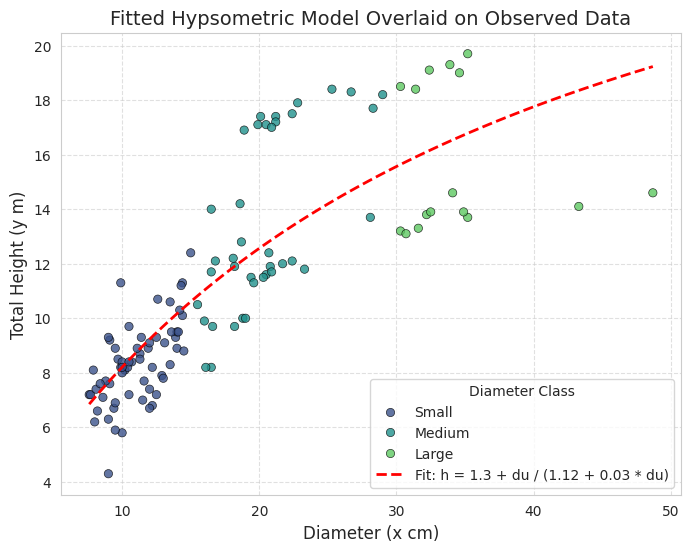

In [ ]:
# Task D: Overlay the Fitted Model on Task B Graph

# Create the figure
plt.figure(figsize=(8, 6))

# Scatter plot of observed data, categorized by diameter class
sns.scatterplot(data=data_df, x='x', y='y', hue='diameter_class',
                alpha=0.8, edgecolor='black', palette="viridis")

# Generate fitted values using the model from Task C (Model 11 from Paulo et al. 2011)
du_fit = np.linspace(min(data_df['x']), max(data_df['x']), 100)
h_fit = 1.3 + (du_fit / (a_fit + b_fit * du_fit))  # Apply the fitted equation

# Add the fitted curve to the plot with a thicker line
plt.plot(du_fit, h_fit, color='red', linestyle="--", linewidth=2,
         label=f'Fit: h = 1.3 + du / ({a_fit:.2f} + {b_fit:.2f} * du)')

# Improve labels and title
plt.xlabel("Diameter (x cm)", fontsize=12)
plt.ylabel("Total Height (y m)", fontsize=12)
plt.title("Fitted Hypsometric Model Overlaid on Observed Data", fontsize=14)

# Adjust legend placement to avoid overlapping with data points
plt.legend(title="Diameter Class", loc="lower right", fontsize=10, frameon=True)

# Improve grid visibility
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

In [ ]:
# Task E: Checking Model Assumptions

# Compute residuals: observed height - predicted height
data_df['residuals'] = data_df['y'] - (1.3 + data_df['x'] / (a_fit + b_fit * data_df['x']))


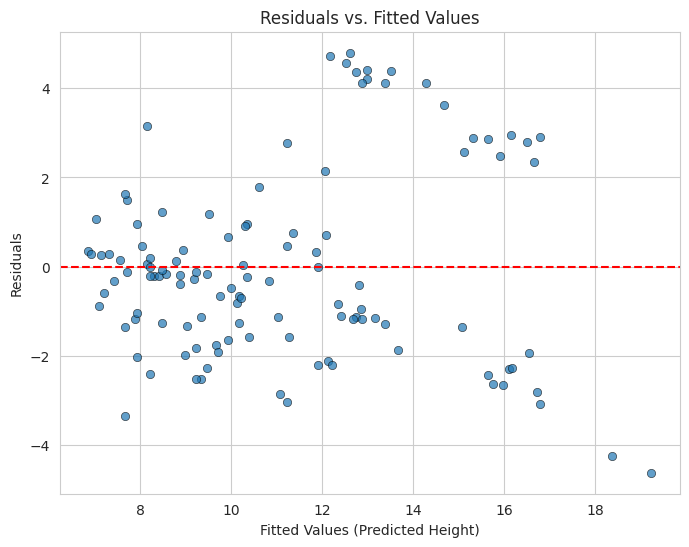

In [ ]:
# 1 - Residuals vs. Fitted Values (Checking for Patterns)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=(1.3 + data_df['x'] / (a_fit + b_fit * data_df['x'])),
                y=data_df['residuals'], alpha=0.7, edgecolor='black')
plt.axhline(y=0, color='red', linestyle="--", linewidth=1.5)
plt.xlabel("Fitted Values (Predicted Height)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.grid(True)
plt.show()

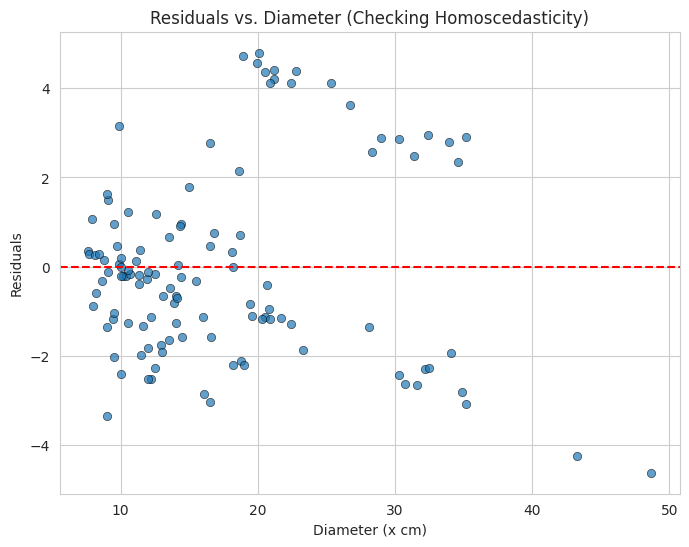

In [ ]:
# 2 - Checking Homoscedasticity (Constant Variance of Residuals)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_df['x'], y=data_df['residuals'], alpha=0.7, edgecolor='black')
plt.axhline(y=0, color='red', linestyle="--", linewidth=1.5)
plt.xlabel("Diameter (x cm)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Diameter (Checking Homoscedasticity)")
plt.grid(True)
plt.show()

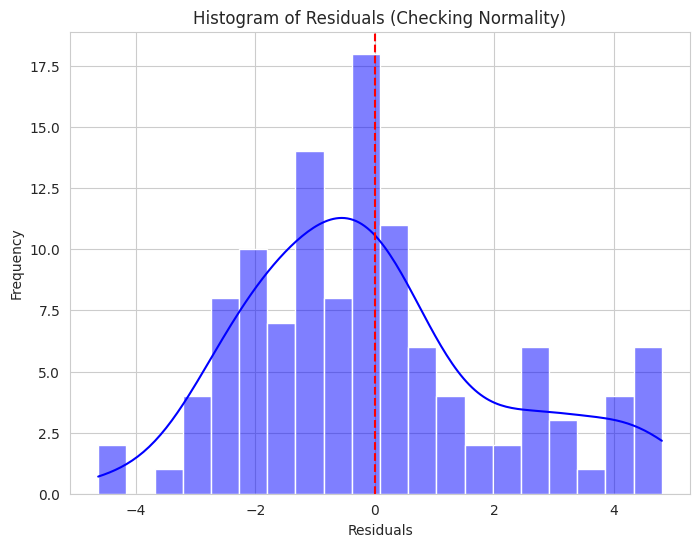

In [ ]:
# 3 - Checking Normality of Residuals

# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(data_df['residuals'], bins=20, kde=True, color="blue")
plt.axvline(x=0, color='red', linestyle="--", linewidth=1.5)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals (Checking Normality)")
plt.show()

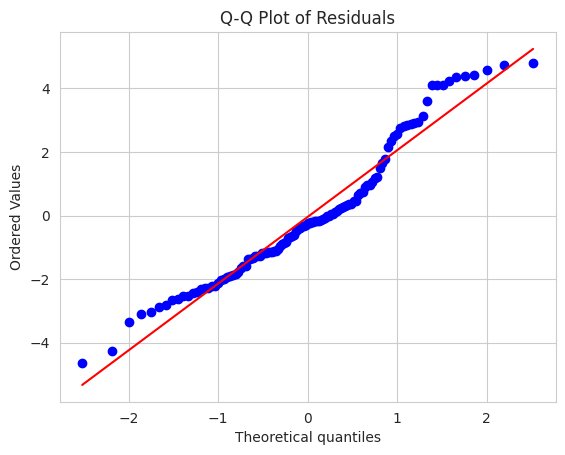

In [ ]:
# Q-Q Plot (Quantile-Quantile Plot)
stats.probplot(data_df['residuals'], dist="norm", plot=pylab)
pylab.title("Q-Q Plot of Residuals")
pylab.show()

In [ ]:
# 4 - Checking for Independence of Residuals (Durbin-Watson Test)
dw_test = durbin_watson(data_df['residuals'])

# Create a summary table
dw_table = pd.DataFrame({
    "Metric": ["Durbin-Watson Statistic"],
    "Value": [round(dw_test, 2)]
})

# Display the table using tabulate
print("\nDurbin-Watson Test Summary:")
print(tabulate(dw_table, headers='keys', tablefmt='fancy_grid', numalign="center", stralign="center"))


Durbin-Watson Test Summary:
╒════╤═════════════════════════╤═════════╕
│    │         Metric          │  Value  │
╞════╪═════════════════════════╪═════════╡
│ 0  │ Durbin-Watson Statistic │   0.9   │
╘════╧═════════════════════════╧═════════╛


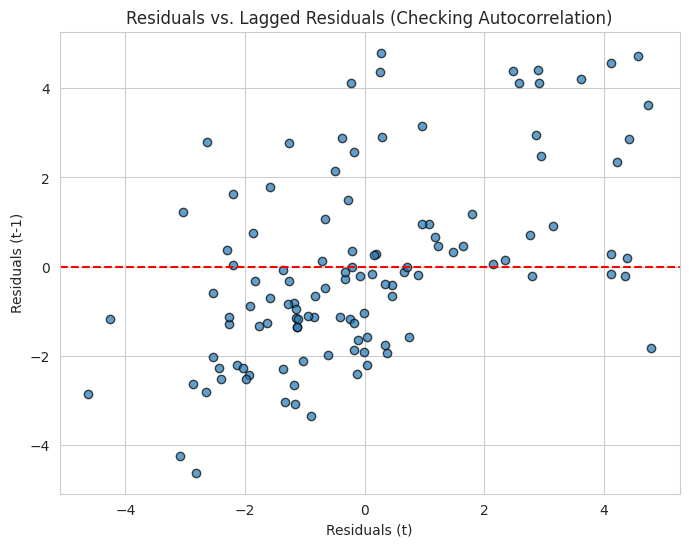

In [ ]:
# 5 - Scatter plot of residuals vs lagged residuals (Checking for autocorrelation)
plt.figure(figsize=(8, 6))
plt.scatter(data_df['residuals'].iloc[:-1], data_df['residuals'].iloc[1:], alpha=0.7, edgecolor='black')
plt.axhline(y=0, color='red', linestyle="--", linewidth=1.5)
plt.xlabel("Residuals (t)")
plt.ylabel("Residuals (t-1)")
plt.title("Residuals vs. Lagged Residuals (Checking Autocorrelation)")
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

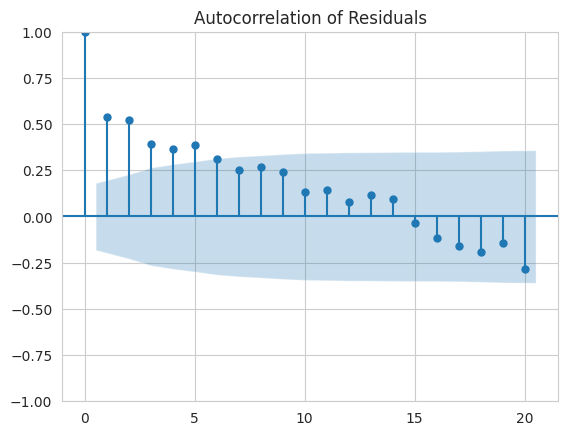

In [ ]:
# 6 - Autocorrelation Function (ACF) plot
plt.figure(figsize=(8, 6))
plot_acf(data_df['residuals'], lags=20)
plt.title("Autocorrelation of Residuals")
plt.show()

In [ ]:
# Task F – Estimate Tree Biomass using Literature Model (Lopes et al., Pinus pinaster)

# Biomass model 11 from Lopes et al.:
# log(B) = 3.769 + 2.706 * log(d)
# B = total dry biomass in kg, d = diameter in cm

# Apply model to estimate biomass per tree
data_df['log_d'] = np.log(data_df['x'])  # 'x' is diameter in cm
data_df['log_biomass'] = 3.769 + 2.706 * data_df['log_d']
data_df['biomass_kg'] = np.exp(data_df['log_biomass'])

# Select relevant columns
biomass_table = data_df[['x', 'biomass_kg']].sort_values(by='biomass_kg', ascending=False).head(5)

# Rename columns for clarity
biomass_table.columns = ["Diameter (cm)", "Estimated Biomass (kg)"]

# Print formatted table
print("\nEstimated Biomass of the 5 Largest Trees (by Biomass)")
print(tabulate(biomass_table, headers="keys", tablefmt="fancy_grid", numalign="center"))


Estimated Biomass of the 5 Largest Trees (by Biomass)
╒════╤═════════════════╤══════════════════════════╕
│    │  Diameter (cm)  │  Estimated Biomass (kg)  │
╞════╪═════════════════╪══════════════════════════╡
│ 67 │      48.7       │       1.59702e+06        │
├────┼─────────────────┼──────────────────────────┤
│ 63 │      43.3       │       1.16196e+06        │
├────┼─────────────────┼──────────────────────────┤
│ 62 │      35.2       │          663438          │
├────┼─────────────────┼──────────────────────────┤
│ 82 │      35.2       │          663438          │
├────┼─────────────────┼──────────────────────────┤
│ 66 │      34.9       │          648248          │
╘════╧═════════════════╧══════════════════════════╛


In [ ]:
# Sum total biomass in the plot (in kg)
total_biomass_plot = data_df['biomass_kg'].sum()
print(f"\nTotal biomass in the plot: {total_biomass_plot:.2f} kg")


Total biomass in the plot: 18743396.69 kg


In [ ]:
# Define plot area in hectares
plot_area_ha = 0.05  # 500 m² = 0.05 ha for Pinus pinaster

# Calculate biomass per hectare (kg/ha)
biomass_per_ha = total_biomass_plot / plot_area_ha
print(f"Estimated biomass per hectare: {biomass_per_ha:.2f} kg/ha")

Estimated biomass per hectare: 374867933.86 kg/ha


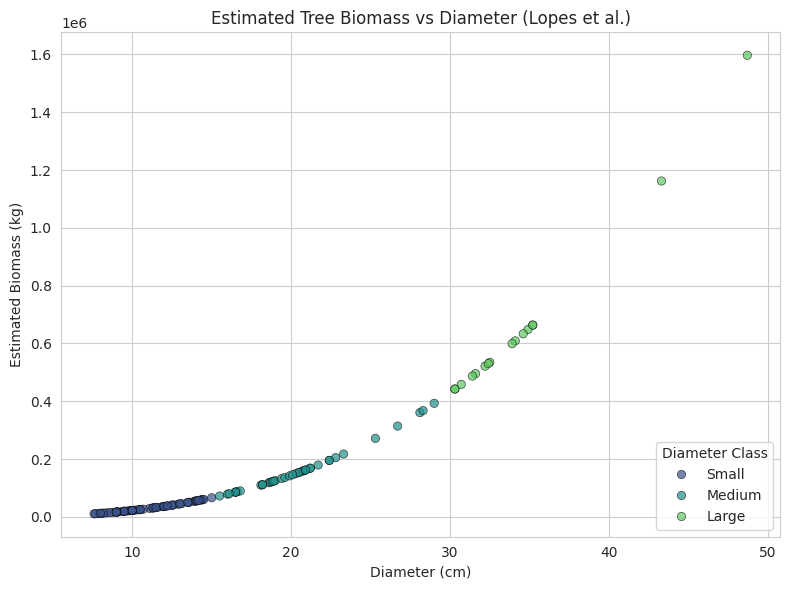

In [ ]:
# Plot biomass vs diameter

plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_df, x='x', y='biomass_kg', hue='diameter_class', palette='viridis', alpha=0.7, edgecolor='black')
plt.xlabel("Diameter (cm)")
plt.ylabel("Estimated Biomass (kg)")
plt.title("Estimated Tree Biomass vs Diameter (Lopes et al.)")
plt.grid(True)
plt.legend(title='Diameter Class', loc='lower right')
plt.tight_layout()
plt.show()